Whitney Kenner
HW3
6/12/23
u0777962
CS 6017

PART 1: Data Acquisition

note: accidentally did part 1 using API calls before realizing I was supposed to scrape, so the following 2 sections are commented out because it was my original incorrect work RIP

In [1]:
# #Grab the first 5 pages of stories from hackernews.
# import requests
# import json
# response = requests.get("https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty")
# print("Status code: ", response.status_code)
# submissionIDs = response.json()
# print(submissionIDs)

    

In [2]:
# import datetime
# import pandas as pd

# submissions_dict = []
# for subID in submissionIDs[:150]:
#     temp_dict = {}
#     url = " https://hacker-news.firebaseio.com/v0/item/" + str(subID) + ".json?print=pretty"
#     article = requests.get(url)
#     #print(f"id: {subID} \t status: {article.status_code}")
#     article_j = article.content.decode( "utf-8" )
#     article_dict = json.loads(article_j)

#     temp_dict["rank"] = article_dict['id']
#     temp_dict["length title"] = len(article_dict['title'])
#     temp_dict["time"] = datetime.datetime.fromtimestamp(article_dict['time']).strftime("%H")
#     if 'score' in article_dict:
#         temp_dict["points"] = article_dict['score']
#     else:
#         temp_dict["points"] = 0
#     if 'kids' in article_dict:
#         temp_dict["num comments"] = len(article_dict['kids']) 
#     else:
#         temp_dict["num comments"] = 0

#     submissions_dict.append(temp_dict)

# #print(json.dumps(submissions_dict, indent=4))

# #convert to dataframe
# submissions_df = pd.DataFrame(submissions_dict)

# #save as csv file
# submissions_df.to_csv('hackerPosts.csv', index=False)

In [3]:
#correct work begins
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import string 
import re
import time

ranks = []
title_lengths = []
age_in_hours = []
points = []
comment_counts = []

for i in range(5):
    url= "https://news.ycombinator.com/?p=" + str(i+1)

    with urllib.request.urlopen (url) as response:
        html = response.read()
        html = html.decode("utf-8")

    with open ("hackernews" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)

    soup = BeautifulSoup(html, 'html.parser')



    #scraping rank
    for post in soup.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))
    #print(posts)

    #scraping length of title
    for title in soup.find_all(class_="titleline"):
        title_lengths.append(len(title.text))

    #scraping age of post
    for age  in soup.find_all(class_="age"):
        age_str = str(age.text)
        #print(age.text)
        age_str = age_str.removesuffix(" hours ago")
        age_str = age_str.removesuffix(" hour ago")
        if " day ago" in age_str:
            age_in_hours.append(24)
        elif " days ago" in age_str:
            modified_string = age_str.replace(" days ago", "")
            age_int = int(modified_string)
            age_in_hours.append(24*age_int)
        elif " minutes ago" in age_str:
            age_in_hours.append(0)
        elif " minute ago" in age_str:
            age_in_hours.append(0)
        else:
            age_in_hours.append(int(age_str))

    #scraping points and comments
    for subtext in soup.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            point = int(re.search(r'\d+', str(score.text)).group())

        for atag in subtext.find_all("a"):
            if atag.text.endswith("comments"):
                a_string = str(atag.text)
                comments = int(re.search(r'\d+', a_string).group())
        comment_counts.append(int(comments))
        points.append(int(point))
    time.sleep(5)


#creating a data frame
submissions_df1 = pd.DataFrame({"rank": ranks, "titleLength": title_lengths, "ageInHours": age_in_hours, "points": points, "commentCount": comment_counts})
print(submissions_df1)

# #save as csv file
submissions_df1.to_csv('hackerPosts.csv', index=False)

     rank  titleLength  ageInHours  points  commentCount
0       1           33           1      33             7
1       2           99           3      82            34
2       3           76           3      66            22
3       4           49           3      40             9
4       5           63           6     425           438
..    ...          ...         ...     ...           ...
145   146           31          22      70            18
146   147           62           7      52            50
147   148           78          24      26             2
148   149           92           4       5             0
149   150           43          11      50            38

[150 rows x 5 columns]


PART 2: Regression

We're interested in how to get a high-ranking story on Hackernews. Explore several possible least squares regressions to predict a story's rank based on the other variables (and combinations thereof). Include at least 3 different regressions. Compare/contrast them. Which is the most useful.  What are the R^2 scores, p-values for coefficients, and values of the coefficients - and what do these tell us?  Plot at least one of your regressions (see my example below.)

Are there linear relationships between any of the variables? 

Note: There are a number of issues that will cause our models to not match the real ranking of articles (to a high percentage).

There is a complicated formula being used to rank the articles that doesn't directly map to our data.
The displayed rank of an article is not immediately/continuously updated.
The age (in hours) we are recording for any article over a day old is approximate.
Because of this, do not expect to see an R^2 value of over 40% for any of the predictive formulas that you choose.

In [4]:
import statsmodels.formula.api as sm

submissions_df = pd.read_csv('hackerPosts.csv')
age_mult_ols = sm.ols(formula="rank ~ commentCount + points + ageInHours", data=submissions_df).fit()
age_mult_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     32.14
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           5.18e-16
Time:                        19:40:42   Log-Likelihood:                -740.03
No. Observations:                 150   AIC:                             1488.
Df Residuals:                     146   BIC:                             1500.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       46.8830      4.822      9.722      0.000      37.352      56.414
commentCount     0.0446      0.025      1.784      0.076      -0.005       0.094
points          -0.1389      0.032     -4.291      0.000      -0.203      -0.075
ageInHours       3.4281      0.353      9.723      0.000       2.731       4.125
==============================================================================
Omnibus:                        5.725   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.502
Skew:                           0.417   Prob(JB):                       0.0639
Kurtosis:                       2.570   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
#comment count vs points
#this is a bad comparison because neither are independant/dependant
comment_points_ols = sm.ols(formula="commentCount ~ points", data=submissions_df).fit()
comment_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           commentCount   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     235.1
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           2.24e-32
Time:                        19:40:42   Log-Likelihood:                -919.84
No. Observations:                 150   AIC:                             1844.
Df Residuals:                     148   BIC:                             1850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -30.7336     11.742     -2.617      0.010     -53.937      -7.531
points         0.9652      0.063     15.334      0.000       0.841       1.090
==============================================================================
Omnibus:                      100.593   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1881.121
Skew:                           1.956   Prob(JB):                         0.00
Kurtosis:                      19.902   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
#age vs comment count 
comment_age_ols = sm.ols(formula="commentCount ~ ageInHours", data=submissions_df).fit()
comment_age_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           commentCount   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     14.83
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           0.000175
Time:                        19:40:42   Log-Likelihood:                -984.02
No. Observations:                 150   AIC:                             1972.
Df Residuals:                     148   BIC:                             1978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3367     23.930      0.307      0.760     -39.951      54.625
ageInHours     6.2089      1.612      3.851      0.000       3.023       9.395
==============================================================================
Omnibus:                      201.945   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10089.016
Skew:                           5.372   Prob(JB):                         0.00
Kurtosis:                      41.714   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
#age and rank
age_rank_ols = sm.ols(formula="rank ~ ageInHours", data=submissions_df).fit()
age_rank_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     63.64
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           3.77e-13
Time:                        19:40:42   Log-Likelihood:                -751.24
No. Observations:                 150   AIC:                             1506.
Df Residuals:                     148   BIC:                             1513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.7629      5.069      8.435      0.000      32.745      52.781
ageInHours     2.7251      0.342      7.977      0.000       2.050       3.400
==============================================================================
Omnibus:                        6.162   Durbin-Watson:                   0.615
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.330
Skew:                           0.378   Prob(JB):                       0.0696
Kurtosis:                       2.471   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Rank')

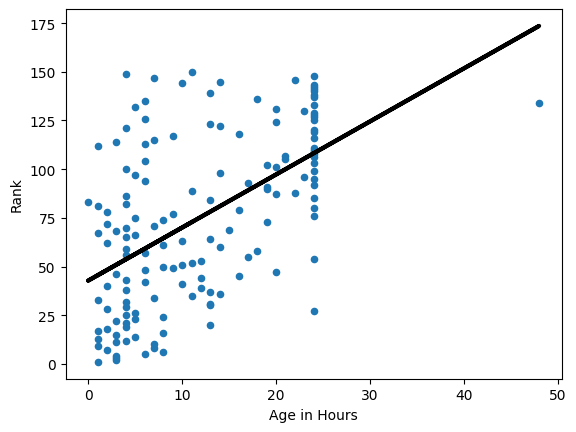

In [8]:
import matplotlib.pyplot as plt

submissions_df.plot.scatter(x='ageInHours', y='rank')
plt.plot(submissions_df["ageInHours"], age_rank_ols.predict(submissions_df["ageInHours"]), linewidth=3, color="black")
plt.xlabel("Age in Hours")
plt.ylabel("Rank")


In [9]:
#rank and points + comments
rank_points_ols = sm.ols(formula="rank ~ commentCount + points", data=submissions_df).fit()
rank_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5756
Date:                Fri, 30 Jun 2023   Prob (F-statistic):              0.564
Time:                        19:40:43   Log-Likelihood:                -777.48
No. Observations:                 150   AIC:                             1561.
Df Residuals:                     147   BIC:                             1570.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       77.5637      4.665     16.627      0.000      68.345      86.783
commentCount     0.0321      0.032      1.004      0.317      -0.031       0.095
points          -0.0402      0.039     -1.022      0.309      -0.118       0.038
==============================================================================
Omnibus:                       57.529   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.827
Skew:                           0.002   Prob(JB):                       0.0121
Kurtosis:                       1.812   Cond. No.                         339.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
#rank vs points + age

#best one so far!!!!
#rank vs points + age
rank_points_ols = sm.ols(formula="rank ~ points + ageInHours", data=submissions_df).fit()
rank_points_ols.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     45.94
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           3.18e-16
Time:                        19:40:43   Log-Likelihood:                -741.65
No. Observations:                 150   AIC:                             1489.
Df Residuals:                     147   BIC:                             1498.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.8065      4.820      9.504      0.000      36.281      55.332
points        -0.0951      0.021     -4.477      0.000      -0.137      -0.053
ageInHours     3.3957      0.355      9.573      0.000       2.695       4.097
==============================================================================
Omnibus:                        7.941   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.302
Skew:                           0.555   Prob(JB):                       0.0157
Kurtosis:                       2.689   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Which is the most useful.  What are the R^2 scores, p-values for coefficients, and values of the coefficients - and what do these tell us?

- The most useful least squares regression I found (for rank) was rank vs points and age in hours
- The closer the R^2 is to 1, the stronger the correlation, so this R^2 being 0.421 meaning this model explains 42.1% of the variability in rank. soooooooo not great but the highest R^2 I could find (with good P values). 
- The P values are 0.00 for both points and age in hours, so this is considered to be significant!! This P value indicates that the data is very compatible with this statistcial model 
- The values of the coefficients are: -0.0711 for points and 3.1954 for ageInHours. This is the amount that the dependant variable (rank) will shift based on a 1 unit shift in each of these independant variables. this is very interesting because it indicated that the points go up, the rank marginally goes down...... huh


Are there linear relationships between any of the variables? 
comments vs points had the strongest linear relationship, but it still onlu had an R squared value of 0.529, so it is not a STONG linear relationship, but it still exists 

PART 3 - Classification

As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.

There are a number of (outdated) ranking formulas for HN publicly available. Take a look at least one of them and perform a regression using the formula to see if least squares regression can compute the coefficients correctly.

Include plots showing your regression (for the functions of 1 or 2 variables and your predicted score for an article). What do your regressions tell you about making the front page?

An example of my computed score vs the actual ranks can be seen here:

In [11]:
#make a new column for whether something is on the front page
submissions_df['onFrontPage'] = [0 if x > 30 else 1 for x in submissions_df['rank']]

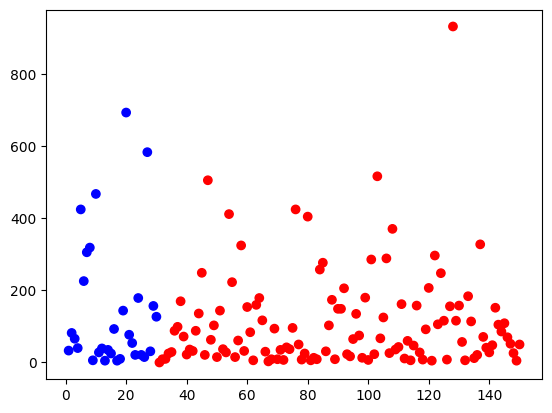

In [12]:
import numpy as np
colors = {0:'red', 1: 'blue'}
rank_point_plt = plt.scatter(x=submissions_df['rank'], y=submissions_df['points'], c=submissions_df['onFrontPage'].map(colors))
logistic = lambda x: 1 / ( 1 + np.exp(-x) )

Score2 = []
for p,t in zip(submissions_df['points'],submissions_df['ageInHours']):
    Score2.append((p-1)/((t+2)**1.8))
submissions_df['Score2'] = Score2

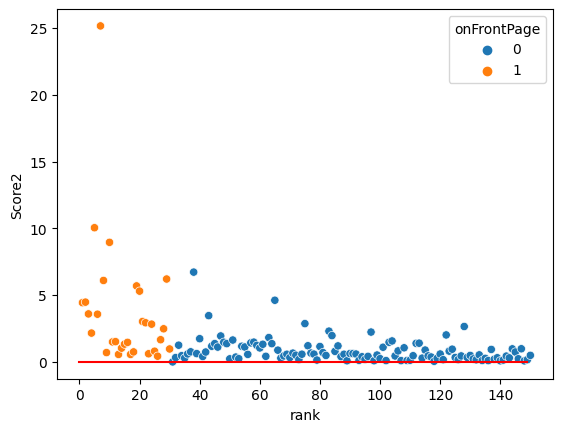

In [13]:
import seaborn as sns

sns.scatterplot(y='Score2',x='rank',hue='onFrontPage',data=submissions_df)
xs = np.linspace(submissions_df['Score2'][30], submissions_df['Score2'][30], 150)
plt.plot(xs, color="red")

Optimization terminated successfully.
         Current function value: 0.372062
         Iterations 7


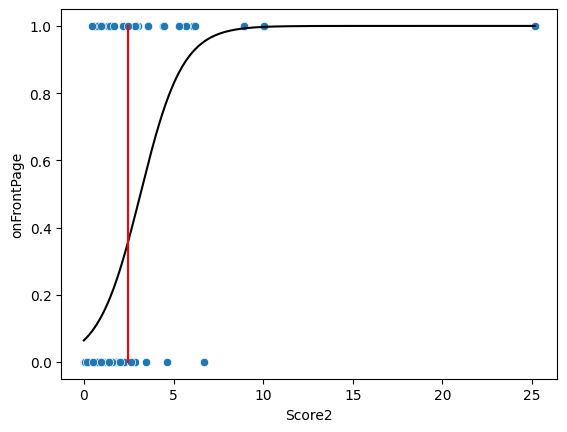

In [14]:
sns.scatterplot(x='Score2', y='onFrontPage',data=submissions_df)
log_model = sm.logit(formula="onFrontPage ~ Score2", data=submissions_df).fit()
logistic = lambda x: 1 / ( 1 + np.exp(-x) )

x = np.linspace(submissions_df['Score2'].min(), submissions_df['Score2'].max(), 1000)
par = dict(log_model.params)
plt.plot(x, logistic(par['Intercept'] + par['Score2'] * x), color='Black')

prob_top_30 = 0.50
estimated_score_toPass = np.log(0.5) - par['Intercept'] / par['Score2']

plt.plot( [estimated_score_toPass, estimated_score_toPass], [0, 1], 'r' )

What do your regressions tell you about making the front page?

our data appears to be underfitted, indicating my equation for my Score2 doesn't contain all of the variables influencing what makes it on the front page, which makes sense
HackerNews probably has a much more complex algorithm that takes many factors into account that are not part of my predictive model